## Import the necessary libraries

In [1]:
import numpy as np
import missingno as miss
import os
import glob
from pathlib import Path
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn
from xgboost import XGBClassifier
%matplotlib inline

## Importing Data

In [2]:
print(f"Current directory: {Path.cwd()}")
print(f"Home directory: {Path.home()}")

Current directory: /Users/davidburton/DS/M3/KickstarterSuccessClassifier/notebooks
Home directory: /Users/davidburton


In [5]:
path = "/Users/davidburton/DS/M3/KickstarterSuccessClassifier/data/interim/ks-projects-201801.csv"
path_processed = "/Users/davidburton/DS/M3/KickstarterSuccessClassifier/data/processed/ks-projects-201801.csv"
path_processed2 = "../data/processed/explored.csv"

In [6]:
df = pd.read_csv(path,
                 encoding = "ISO-8859-1")
df.head(2)

,name,sub_category,category,currency,deadline,launched,outcome,backers,country,pledged,goal,deadline_dayofweek,deadline_weekofyear,launched_dayofweek,launched_weekofyear,launch_time,launch_hourofday,duration,duration_days
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 00:00:00,2015-08-11 12:12:28,failed,0,GB,0,1533,4,41,1,33,12:12:28,12,58 days 11:47:32.000000000,58
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01 00:00:00,2017-09-02 04:43:57,failed,15,US,2421,30000,2,44,5,35,04:43:57,4,59 days 19:16:03.000000000,59


In [7]:
df.shape

(331675, 19)

In [8]:
df.isnull().any()

name                    True
sub_category           False
category               False
currency               False
deadline               False
launched               False
outcome                False
backers                False
country                False
pledged                False
goal                   False
deadline_dayofweek     False
deadline_weekofyear    False
launched_dayofweek     False
launched_weekofyear    False
launch_time            False
launch_hourofday       False
duration               False
duration_days          False
dtype: bool

In [9]:
# Primer
# What I want to predict
target = "outcome"

# The Features or Attributes
features = df.drop(target,1).columns

In [10]:
features_by_dtype = {}

for f in features:
    dtype = str(df[f].dtype)
    if dtype not in features_by_dtype.keys():
        features_by_dtype[dtype] = [f]
    else:
        features_by_dtype[dtype] += [f]
        
for k in features_by_dtype.keys():
    string = "%s: %s" % (k , len(features_by_dtype[k]))
    print(string)

object: 9
int64: 9


In [11]:
keys = iter(features_by_dtype.keys())

In [ ]:
k = next(keys)
dtype_list = features_by_dtype[k]
for d in dtype_list:
    string = "%s: %s" % (d,len(df[d].unique()))
    print(string)


In [ ]:
sns.pairplot(df)

In [ ]:
g = sns.pairplot(df[["backers", "pledged", "goal", "deadline_dayofweek",
                    "deadline_weekofyear", "launched_dayofweek", 
                    "launched_weekofyear", "launch_hourofday", "duration_days"]],
                  diag_kind="hist")
 
for ax in g.axes.flat: 
    plt.setp(ax.get_xticklabels(), rotation=45)

In [ ]:
df.columns

In [ ]:
df['outcome'].value_counts().plot(kind='box');

In [ ]:
df.columns

In [12]:
df.drop(['name'], axis = 1, inplace=True)

In [ ]:
df.category.value_counts()

In [ ]:
df.corr(method='spearman')

In [ ]:
df.corr(method='pearson')

In [ ]:
df.groupby('outcome').nunique()
# less backers means more likely to fail
# longer campaigns more likely to fail 

In [ ]:
df.category.unique()

In [ ]:
#create a category dictionary
category_dict = {}
category_list = ['Publishing', 'Film & Video', 'Music', 'Food', 'Crafts', 'Games',
       'Design', 'Comics', 'Fashion', 'Theater', 'Art', 'Photography',
       'Technology', 'Dance', 'Journalism']

In [ ]:
df.category.value_counts(normalize=True).plot(kind = 'pie', figsize=(14,7))

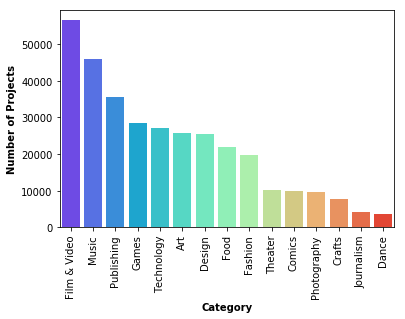

In [13]:

df_cat = df.category.value_counts()
df_cat = pd.DataFrame(df_cat)
df_cat = df_cat.rename(columns={'category':'count'})
df_cat['category'] = df_cat.index
ax = sns.barplot(x="category" , y= "count", data= df_cat, palette='rainbow')
ax.set_xlabel("Category", fontweight='bold')
ax.set_ylabel("Number of Projects", fontweight='bold')
plt.xticks(rotation=90);


Start doing some modeling

In [14]:
#encode
df.dtypes

sub_category           object
category               object
currency               object
deadline               object
launched               object
outcome                object
backers                 int64
country                object
pledged                 int64
goal                    int64
deadline_dayofweek      int64
deadline_weekofyear     int64
launched_dayofweek      int64
launched_weekofyear     int64
launch_time            object
launch_hourofday        int64
duration               object
duration_days           int64
dtype: object

In [15]:
#convert objects into datetime where appropriate 
df.launch_time = pd.to_datetime(df.launch_time)

In [16]:
df.launched = pd.to_datetime(df.launched)

In [17]:
df.deadline = pd.to_datetime(df.deadline)

In [18]:
#encode
df_dummies = pd.get_dummies(df[['sub_category', 'category', 
                                'currency', 'country']], drop_first=True)


In [19]:
df = df_dummies.merge(df, left_index=True, right_index=True)

In [20]:
#drop original categorical object features
df = df.drop(['sub_category', 'category', 
        'currency', 'country'],1)

In [21]:
df.shape

(331675, 221)

In [ ]:
df.head(2)

In [ ]:
df.columns

In [22]:
#https://elitedatascience.com/python-machine-learning-tutorial-scikit-learn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#families
#random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

#cross-validation pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

#evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score

#for saving models
from sklearn.externals import joblib

In [23]:
#keep only feature known from begining of campaign
X = df.drop(['outcome', 'backers', 'pledged','duration','deadline',
            'launched', 'launch_time'],1)
#Target Variable
y = df.outcome

In [49]:
X=X.astype(int);

In [50]:
y.unique()

array([0, 1])

In [51]:
y.replace('failed',value=0,inplace=True)

In [52]:
y.replace('successful',value=1,inplace=True)

In [53]:
y.value_counts(normalize=True)

0    0.596123
1    0.403877
Name: outcome, dtype: float64

In [54]:
y = y.astype(int)

In [55]:
#split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=123, 
                                                    stratify=y)


Fit the transformer on the training set (saving the means and standard deviations)<br>
Apply the transformer to the training set (scaling the training data)<br>
Apply the transformer to the test set (using the same means and standard deviations)<br>


In [56]:
# fit the transformer
scaler = preprocessing.StandardScaler().fit(X_train)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


In [32]:
# sanity check
X_train_scaled = scaler.transform(X_train)
 


/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  


In [57]:
%%time
X_train_scaled.mean(axis=0)[:10]

CPU times: user 138 ms, sys: 375 ms, total: 513 ms
Wall time: 514 ms


array([-2.37057344e-17, -2.22262181e-17, -4.98081514e-18, -7.23021552e-19,
        3.66866491e-18,  3.74900064e-19, -1.92805747e-18, -3.17593911e-17,
       -1.13541162e-17, -3.51334917e-17])

In [58]:
X_train_scaled.std()

1.0000000000000027

In [59]:
#worked on train set, use same method to scale on test data
X_test_scaled = scaler.transform(X_test)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [60]:
# sanity check
X_test_scaled.mean(axis=0)[:10]

array([-0.00554911, -0.00393863,  0.00078604,  0.00677211,  0.00032418,
       -0.00412589, -0.00142153,  0.00220039,  0.00459201, -0.00382205])

In [61]:
X_test_scaled.std()

1.0065360057758916

In [62]:
#easier method
#pipleine with preprocessing and model
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         RandomForestClassifier(n_estimators=100))

The above is a modeling pipeline that first transforms the data using StandardScaler() and then fits a model using a random forest regressor.

In [63]:
# figuring out hyperparameters 
pipeline.get_params()

{'memory': None,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('randomforestclassifier',
   RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=None, max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
               oob_score=False, random_state=None, verbose=0,
               warm_start=False))],
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'randomforestclassifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, 

In [64]:
#define hyper parameters to tune
hyperparameters = { 'randomforestclassifier__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestclassifier__max_depth': [None, 5, 3, 1]}

Cross-validation<br>
1. Split  data into k equal parts, or "folds" (typically k=10).<br>
2. Preprocess k-1 training folds.<br>
3. Train  model on k-1 folds (e.g. the first 9 folds).<br>
4. Preprocess the hold-out fold using the same transformations from step(2)<br>
5. Evaluate it on the remaining "hold-out" fold (e.g. the 10th fold).<br>
6. Perform steps (2) and (3) k times, each time holding out a different fold.<br>
7. Aggregate the performance across all k folds. This is the performance metric.<br>

In [65]:
%%time
#cross-validation with pipeline
clf = GridSearchCV(pipeline, hyperparameters, cv=10)


CPU times: user 32 µs, sys: 29 µs, total: 61 µs
Wall time: 66 µs


In [66]:
%%time
# Fit and tune model
#clf.fit(X_train, y_train)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype

/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64 wer

KeyboardInterrupt: 

In [67]:
rf = RandomForestClassifier(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}
